In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from joblib import dump
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_absolute_error


In [2]:
def plot_seasonal_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load for each season.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add a 'Season' column to the DataFrame
    data['Month'] = data.index.month
    data['Season'] = data['Month'].apply(lambda x: (
        'Winter' if x in [12, 1, 2] else
        'Spring' if x in [3, 4, 5] else
        'Summer' if x in [6, 7, 8] else
        'Autumn'
    ))
    
    # Group by season and calculate the mean for actual and predicted values
    seasonal_data = data.groupby('Season').mean()
    
    # Plot the seasonal comparison
    plt.figure(figsize=(12, 6))
    plt.plot(seasonal_data.index, seasonal_data['Actual'], label='Actual Load', marker='o')
    plt.plot(seasonal_data.index, seasonal_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Season')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Season')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
def plot_monthly_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load by month.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add a 'Month' column to the DataFrame
    data['Month'] = data.index.month

    # Group by month and calculate the mean for actual and predicted values
    monthly_data = data.groupby('Month').mean()

    # Create month labels corresponding to the months present in the dataset
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    available_months = monthly_data.index
    available_labels = [month_labels[month - 1] for month in available_months]

    # Plot the monthly comparison
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_data.index, monthly_data['Actual'], label='Actual Load', marker='o')
    plt.plot(monthly_data.index, monthly_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Month')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Month')
    plt.xticks(ticks=monthly_data.index, labels=available_labels)
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
def plot_weekday_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load by day of the week.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add a 'DayOfWeek' column to the DataFrame
    data['DayOfWeek'] = data.index.dayofweek

    # Group by day of the week and calculate the mean for actual and predicted values
    weekday_data = data.groupby('DayOfWeek').mean()

    # Create day labels corresponding to the days of the week
    day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    available_days = weekday_data.index
    available_day_labels = [day_labels[day] for day in available_days]

    # Plot the weekday comparison
    plt.figure(figsize=(12, 6))
    plt.plot(weekday_data.index, weekday_data['Actual'], label='Actual Load', marker='o')
    plt.plot(weekday_data.index, weekday_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Day of the Week')
    plt.xticks(ticks=weekday_data.index, labels=available_day_labels)
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
def plot_hourly_comparison(test_index, ys_test_rescaled, predictions_rescaled):
    """
    Plot the average actual and forecasted load by hour of the day.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    """
    # Create a DataFrame to hold the test and prediction data
    data = pd.DataFrame({
        'Actual': ys_test_rescaled.flatten(),
        'Predicted': predictions_rescaled.flatten()
    }, index=test_index)
    
    # Add an 'Hour' column to the DataFrame
    data['Hour'] = data.index.hour

    # Group by hour of the day and calculate the mean for actual and predicted values
    hourly_data = data.groupby('Hour').mean()

    # Create hour labels corresponding to the hours of the day
    available_hours = hourly_data.index
    available_hour_labels = [f'{hour}:00' for hour in available_hours]

    # Plot the hourly comparison
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_data.index, hourly_data['Actual'], label='Actual Load', marker='o')
    plt.plot(hourly_data.index, hourly_data['Predicted'], label='Forecasted Load', marker='o')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Load')
    plt.title('Average Actual Load and Forecasted Load by Hour of the Day')
    plt.xticks(ticks=hourly_data.index, labels=available_hour_labels)
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def plot_results_from_to(test_index, ys_test_rescaled, predictions_rescaled, start_date, end_date):
    """
    Plot the actual and forecasted load for a specified date range.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    - start_date: Start date for the plot.
    - end_date: End date for the plot.
    """
    # Convert start_date and end_date to datetime if they are strings
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    if isinstance(end_date, str):
        end_date = pd.to_datetime(end_date)

    # Create a boolean mask for the date range
    mask = (test_index >= start_date) & (test_index <= end_date)

    # Apply the mask to the test data and predictions
    time_index = test_index[mask]
    ys_test_range = ys_test_rescaled[mask]
    predictions_range = predictions_rescaled[mask]

    # Plotting the actual and forecasted load for the specified date range
    plt.figure(figsize=(24, 5))
    plt.plot(time_index, ys_test_range.flatten(), label='Actual Load')
    plt.plot(time_index, predictions_range.flatten(), label='Forecasted Load')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.title(f'Actual Load and Forecasted Load from {start_date:%Y-%m-%d} to {end_date:%Y-%m-%d}')
    plt.legend()

    # Customize x-axis to show date and day of the week
    plt.xticks(ticks=time_index[::24], labels=[f"{date:%Y-%m-%d}\n{date:%A}" for date in time_index[::24]], rotation=45)
    plt.show()


In [7]:

def plot_results(test_index, ys_test_rescaled, predictions_rescaled, hours_to_plot=720):
    """
    Plot the actual and forecasted load for the first month.

    Parameters:
    - test_index: Datetime index for the test data.
    - ys_test_rescaled: Rescaled actual test values.
    - predictions_rescaled: Rescaled forecasted values.
    - hours_in_month: Number of hours to plot for the first month.
    """
    # Adjust the test index to include only the first month of data
    time_index = test_index[:hours_to_plot]
    ys_test_first_month = ys_test_rescaled[:hours_to_plot]
    predictions_first_month = predictions_rescaled[:hours_to_plot]

    # Plotting the initial month of actual and forecasted load
    plt.figure(figsize=(24, 5))
    plt.plot(time_index, ys_test_first_month.flatten(), label='Actual Load')
    plt.plot(time_index, predictions_first_month.flatten(), label='Forecasted Load')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.title('Actual Load and Forecasted Load for the First Month')
    plt.legend()

    # Customize x-axis to show date and day of the week
    plt.xticks(ticks=time_index[::24], labels=[f"{date:%Y-%m-%d}\n{date:%A}" for date in time_index[::24]], rotation=45)
    plt.show()


In [8]:
def build_and_train_model(xs_train, ys_train, model_config, num_target_features,path_to_save_model):
    """
    Build, train, and evaluate an LSTM model.

    Parameters:
    - xs_train, ys_train: Training data.
    - xs_test, ys_test: Test data.
    - model_config: Dictionary containing LSTM layers configuration and other model parameters.
    - scaler: Scaler used to scale data.
    - num_target_features: Number of output features for the model.

    Returns:
    - model: Trained LSTM model.
    - history: Training history of the model.
    - predictions_rescaled: Rescaled predictions.
    - ys_test_rescaled: Rescaled actual values.
    """
    # Build the LSTM model

    # Determine the split index
    split_index = int(len(xs_train) * 0.8)  # 80% for training, 20% for validation

    # Split the data sequentially
    xs_train_split = xs_train[:split_index]
    ys_train_split = ys_train[:split_index]
    xs_val_split = xs_train[split_index:]
    ys_val_split = ys_train[split_index:]
    num_samples =  xs_train.shape[0]
    num_time_steps = xs_train.shape[1]
    num_features = xs_train.shape[2]
    input_shape = (num_time_steps, num_features)


    model = Sequential()

    for layer_config in model_config['cnn_layers']:
        model.add(Conv1D(filters=layer_config.get('filters', 32), kernel_size=layer_config.get('kernel_size', 5), activation='relu', input_shape=input_shape))
        model.add(MaxPooling1D(pool_size=layer_config.get('pool_size', 2)))
         # Reset input_shape after first layer
        input_shape = None
        
        if 'dropout' in layer_config:
            model.add(Dropout(layer_config['dropout']))
            
    model.add(Flatten())
    model.add(Dense(num_target_features))
        
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    # Define the early stopping and model checkpoint callbacks
    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint(path_to_save_model, monitor='loss', verbose=1, save_best_only=True, mode='min')

    history = model.fit(xs_train_split, ys_train_split, epochs=model_config.get('epochs', 50), batch_size=model_config.get('batch_size', 32), validation_data=(xs_val_split, ys_val_split), callbacks=[early_stopping, checkpoint])

    return model, history


In [9]:
def create_sequences(data, seq_length, forecast_horizon, target_col):
    target_col_index = target_col
    xs, ys = [], []
    target_col_name = data.columns[target_col_index]  
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        x = data.iloc[i:(i + seq_length)].values
      #  x = data.iloc[i:(i + seq_length)].drop(columns=[target_col_name]).values 
        y = data.iloc[(i + seq_length):(i + seq_length + forecast_horizon), target_col].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [10]:
# Load and preprocess data
#datapath= '../data/processed/covid-data/covid_dataset_without_outliers.csv'
train_data_df = pd.read_csv('../data/processed/covid-data/train/covid_dataset_actuals_train.csv', parse_dates=['Time'], index_col='Time')
# Corrected test data: 
test_data_df = pd.read_csv('../data/processed/covid-data/test/covid_dataset_corrected_weather_forecasts.csv', parse_dates=['Time'], index_col='Time')
#Forecasts: 
#test_data_df = pd.read_csv('../data/processed/covid-data/test/covid_dataset_forecasts_test.csv', parse_dates=['Time'], index_col='Time')
#Actuals:
#test_data_df = pd.read_csv('../data/processed/covid-data/test/covid_dataset_actuals_test.csv', parse_dates=['Time'], index_col='Time')


In [11]:
# Limit number of data to have same size as evalution period
EVALUATION_PERIOD_LENGTH = 744
test_data_df = test_data_df.iloc[:EVALUATION_PERIOD_LENGTH]

In [12]:
train_data_df.head()

,Temperature (C),Wind Direction (deg),Wind Speed (kmh),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,,,
2017-03-18 00:00:00,16.764386,285.25,6.25375,0.000000,1.000000,1.031472e+06
2017-03-18 01:00:00,15.729386,285.00,9.20500,0.258819,0.965926,1.007206e+06
2017-03-18 02:00:00,15.816886,316.00,11.28375,0.500000,0.866025,9.861084e+05
2017-03-18 03:00:00,15.919386,327.00,7.16875,0.707107,0.707107,9.707610e+05
2017-03-18 04:00:00,15.769386,282.25,0.78000,0.866025,0.500000,9.622584e+05


In [13]:
test_data_df.head()

,Temperature (C),Wind Direction (deg),Wind Speed (kmh),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,,,
2020-06-27 04:00:00,15.242884,191.875,12.7350,0.866025,5.000000e-01,9.705132e+05
2020-06-27 05:00:00,14.794327,198.750,10.2550,0.965926,2.588190e-01,9.694804e+05
2020-06-27 06:00:00,14.929302,212.750,14.2875,1.000000,6.123234e-17,9.644836e+05
2020-06-27 07:00:00,15.765862,217.250,14.2325,0.965926,-2.588190e-01,9.810288e+05
2020-06-27 08:00:00,18.017364,207.250,15.4800,0.866025,-5.000000e-01,1.021520e+06


In [14]:

load_col = train_data_df.pop('Load (kW)')
train_data_df['Load (kW)'] = load_col

target_col = (train_data_df.columns.get_loc('Load (kW)'))
num_target_features = 1
scaler_num_features = train_data_df.shape[1]

In [15]:
#1. Scale data
scaler = MinMaxScaler()
train_data_df_scaled = pd.DataFrame(scaler.fit_transform(train_data_df), columns=train_data_df.columns, index=train_data_df.index)
test_data_df_scaled = pd.DataFrame(scaler.fit_transform(test_data_df), columns=test_data_df.columns, index=test_data_df.index)

In [16]:
scaler.feature_names_in_

array(['Temperature (C)', 'Wind Direction (deg)', 'Wind Speed (kmh)',
       'hour_of_day_sin', 'hour_of_day_cos', 'Load (kW)'], dtype=object)

In [17]:
# Save the scaler to a file using joblib
#dump(scaler, '../models/scalers/scaler.joblib')

In [18]:

#2. Create sequences pairs of input and output
#In this case we have to configure the target_col-1 to be the index of the target column in the data_df in order to assign in the ys variable
# and have input output pairs of sequences
# seq_length = 8
seq_length = 4
forecast_horizon = 1
xs_train_scaled, ys_train_scaled = create_sequences(train_data_df_scaled, seq_length, forecast_horizon, target_col)
xs_test_scaled, ys_test_scaled = create_sequences(test_data_df_scaled, seq_length, forecast_horizon, target_col)

print(xs_train_scaled.shape, ys_train_scaled.shape)
print(xs_test_scaled.shape, ys_test_scaled.shape)

(28716, 4, 6) (28716, 1)
(740, 4, 6) (740, 1)


# Visualize the problem

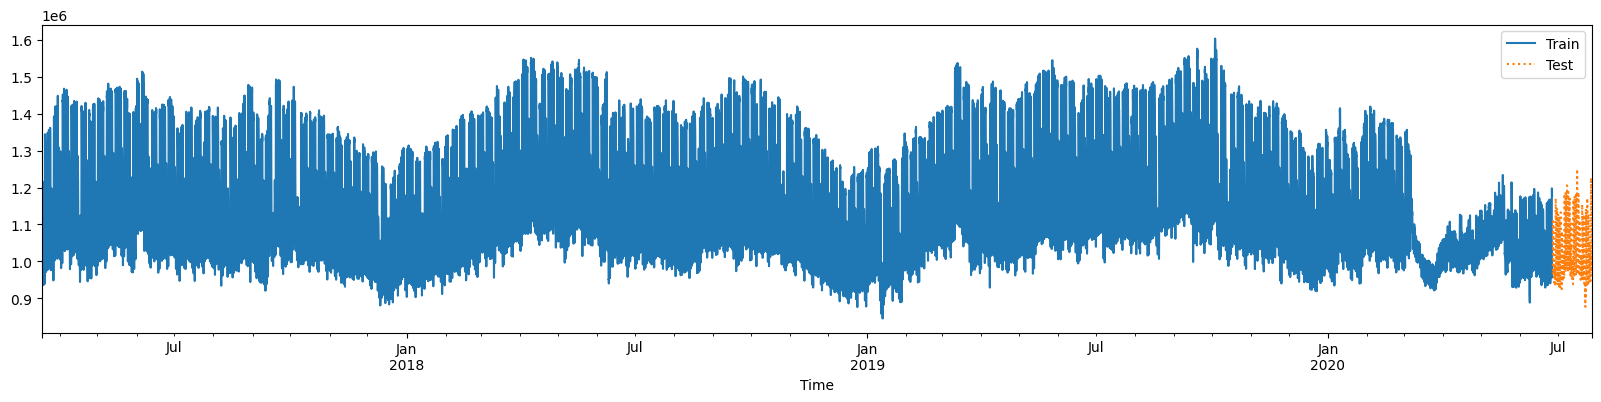

In [19]:
fig, ax = plt.subplots(figsize=(20, 4))
train_data_df['Load (kW)'].plot(ax=ax, label="Train")
test_data_df['Load (kW)'].plot(ax=ax, label="Test", linestyle='dotted')
ax.legend()

In [20]:
xs_train_scaled

array([[[0.49311621, 0.79818118, 0.1896225 , 0.5       , 1.        ,
         0.24540652],
        [0.46247224, 0.79748164, 0.27910855, 0.62940952, 0.98296291,
         0.21339019],
        [0.46506292, 0.88422525, 0.34213918, 0.75      , 0.9330127 ,
         0.18555483],
        [0.46809771, 0.91500525, 0.21736659, 0.85355339, 0.85355339,
         0.16530561]],

       [[0.46247224, 0.79748164, 0.27910855, 0.62940952, 0.98296291,
         0.21339019],
        [0.46506292, 0.88422525, 0.34213918, 0.75      , 0.9330127 ,
         0.18555483],
        [0.46809771, 0.91500525, 0.21736659, 0.85355339, 0.85355339,
         0.16530561],
        [0.46365655, 0.78978664, 0.0236507 , 0.9330127 , 0.75      ,
         0.15408738]],

       [[0.46506292, 0.88422525, 0.34213918, 0.75      , 0.9330127 ,
         0.18555483],
        [0.46809771, 0.91500525, 0.21736659, 0.85355339, 0.85355339,
         0.16530561],
        [0.46365655, 0.78978664, 0.0236507 , 0.9330127 , 0.75      ,
         0.154087

In [21]:
ys_train_scaled

array([[0.15408738],
       [0.15618463],
       [0.16649471],
       ...,
       [0.45408418],
       [0.44936402],
       [0.4394038 ]])

In [22]:
#4. Define the model configuration
model_config = {
  'cnn_layers': [
        {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 2, 'dropout': 0.3}, #Οutput shape: (None, 3, 64)
    ],
    'epochs': 60,
    'batch_size': 64
}

In [23]:
xs_train_scaled.shape
print('Num Samples:', xs_train_scaled.shape[0])
print('Num Time Steps:', xs_train_scaled.shape[1])
print('Num Features:', xs_train_scaled.shape[2])

Num Samples: 28716
Num Time Steps: 4
Num Features: 6


In [24]:
xs_test_scaled.shape

(740, 4, 6)

In [25]:
ys_test_scaled.shape

(740, 1)

In [26]:
#5. Build, train, and evaluate the model
multivariate_load_foreacasting_load_temp_included_model_path_cnn = '../models/multivariate_load_foreacasting_load_cnn.keras'
num_target_features = 1  # The number of output features for the model only load for now

# Define the number of experiments
num_experiments = 10

# Initialize variables to accumulate the total loss and track the best model
total_loss = 0
best_loss = float('inf')
best_model = None

for _ in range(num_experiments):
    # Build and train the model
    model, history = build_and_train_model(
        xs_train_scaled, ys_train_scaled, model_config, num_target_features, path_to_save_model=multivariate_load_foreacasting_load_temp_included_model_path_cnn
    )
    
    # Evaluate the model
    loss = model.evaluate(xs_test_scaled, ys_test_scaled, verbose=0)
    total_loss += loss
    
    # Update the best model if the current model's loss is lower than the best loss
    if loss < best_loss:
        best_loss = loss
        best_model = model

# Calculate the average loss
average_loss = total_loss / num_experiments

print(f'Average Test Loss over {num_experiments} experiments: {average_loss}')
print(f'Best Loss: {best_loss}')

# # Save the best model
# best_model.save(multivariate_load_foreacasting_load_temp_included_model_path)
print(f'Best model saved to {multivariate_load_foreacasting_load_temp_included_model_path_cnn}')

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


172/359 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - loss: 0.1578  
Epoch 1: loss improved from inf to 0.04215, saving model to ../models/multivariate_load_foreacasting_load_cnn.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.1031 - val_loss: 0.0039
Epoch 2/100
210/359 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 0.0128
Epoch 2: loss improved from 0.04215 to 0.01138, saving model to ../models/multivariate_load_foreacasting_load_cnn.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 0.0124 - val_loss: 0.0028
Epoch 3/100
204/359 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 0.0092
Epoch 3: loss improved from 0.01138 to 0.00828, saving model to ../models/multivariate_load_foreacasting_load_cnn.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 0.0089 - val_loss: 0.0020
Epoch 4/100
213/359 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 0.0073
Epoch 4: loss improved from 0.00828 to 0.00649, saving model to ../models/multivariate_load_foreacasting_load_cnn.keras
359/359 ━━━━━━━━━━━━━━━

In [27]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 2, 32)          │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,925 (7.52 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,284 (5.02 KB)

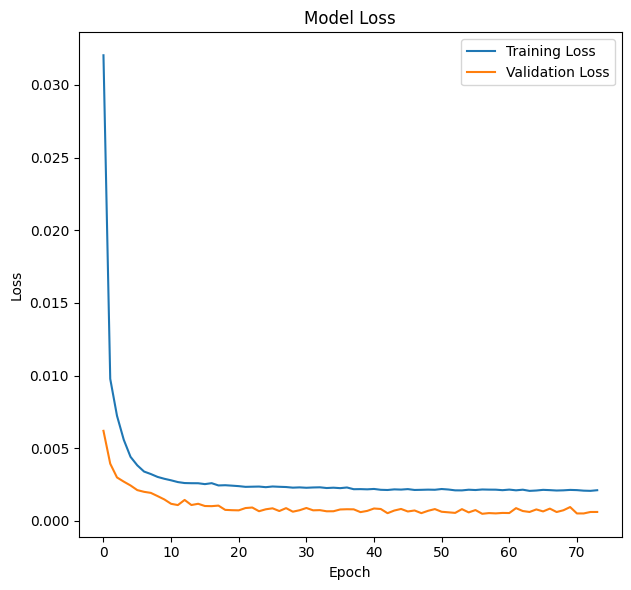

In [28]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [29]:
#     # Evaluate the model
loss = model.evaluate(xs_test_scaled, ys_test_scaled, verbose=0)
print(f'Test Loss: {loss}')

Test Loss: 0.0010987152345478535


In [30]:
# Load the best model from the path into model variable
model = tf.keras.models.load_model(multivariate_load_foreacasting_load_temp_included_model_path_cnn)
print('Best model loaded from path.')

NameError: name 'multivariate_load_foreacasting_load_temp_included_model_path' is not defined

In [ ]:
xs_test_scaled.shape

In [ ]:
#5. Build, train, and evaluate the model

# Make predictions on the test set
predictions_scaled = model.predict(xs_test_scaled) # contains only load
predictions_scaled

In [ ]:
# Rescale the predictions and actual values
# predictions=> contains values for target column (Load)
# but our scaler was trained on all columns so we have to inverse transform all columns
# so we need to padd with zeros the other columns
num_of_missing_training_features = train_data_df.shape[1] - num_target_features

padding_for_missing_training_features = np.zeros((predictions_scaled.shape[0], num_of_missing_training_features))
padding_for_missing_training_features

In [ ]:
padding_for_missing_training_features.shape

In [ ]:
predictions_scaled

In [ ]:
predictions_scaled.shape

In [ ]:
data_to_be_invert_from_scaling = np.hstack([padding_for_missing_training_features, predictions_scaled])
data_to_be_invert_from_scaling

In [ ]:
data_to_be_invert_from_scaling

In [ ]:
#Model outputs 
predictions= scaler.inverse_transform(data_to_be_invert_from_scaling)[:, target_col]
predictions

In [ ]:
ys_test_scaled

In [ ]:
xs_test_scaled.shape

In [ ]:
padding_for_missing_training_features = np.zeros((ys_test_scaled.shape[0], num_of_missing_training_features))
ys_test_scaled = np.hstack([padding_for_missing_training_features, ys_test_scaled])
ys_test_scaled
ys_test = scaler.inverse_transform(ys_test_scaled)[:,target_col]

In [ ]:
ys_test.shape

In [ ]:
ys_test

In [ ]:
(abs(ys_test-predictions)).sum()

In [ ]:
predictions

In [ ]:
predictions.shape

In [ ]:
mae = mean_absolute_error(ys_test, predictions)
print(f"MAE: {mae}")

In [ ]:
#6. Plot the results
test_index =test_data_df[seq_length:].index
hours_to_plot = -1 # Approximately one month

plot_results(test_index, ys_test, predictions, hours_to_plot=hours_to_plot)

In [ ]:
plot_results_from_to(test_index, ys_test, predictions,'2019-06-01', '2019-07-01')

In [ ]:
# Assuming you have your test_index, ys_test_rescaled, and predictions_rescaled already defined
plot_seasonal_comparison(test_index, ys_test, predictions)

In [ ]:
# Assuming you have your test_index, ys_test_rescaled, and predictions_rescaled already defined
plot_monthly_comparison(test_index, ys_test, predictions)

In [ ]:
# Assuming you have your test_index, ys_test_rescaled, and predictions_rescaled already defined
plot_weekday_comparison(test_index, ys_test, predictions)

In [ ]:
plot_hourly_comparison(test_index, ys_test, predictions)

In [ ]:
model.summary()

In [ ]:
target_col_name = train_data_df.columns[target_col]
predictions_df = pd.DataFrame(predictions, columns=[target_col_name], index=test_index)
predictions_df

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
train_data_df['Load (kW)'].plot(ax=ax, label="Train")
test_data_df['Load (kW)'].plot(ax=ax, label="Test")
predictions_df.plot(ax=ax, label="Forecasted Load")
ax.legend()

In [ ]:
actual = test_data_df['Load (kW)']
mape = np.mean(np.abs((actual[seq_length:] - predictions) / actual[seq_length:])) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")